In [1]:
!pip install recfast4py

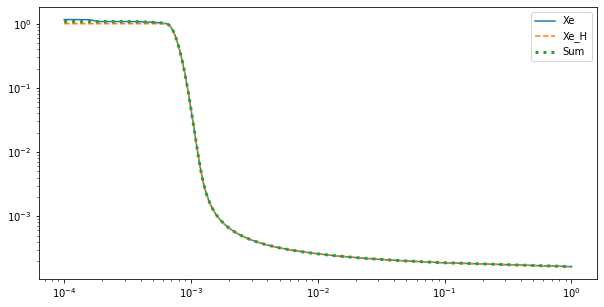

In [16]:
from recfast4py import recfast
import numpy as np
Yp = 0.24
T0 = 2.725

Om = 0.26
Ob = 0.044
OL = 0.0
Ok = 0.0
h100 = 0.71
Nnu = 3.04
F = 1.14
fDM = 0.0

zarr, xe_h, xe_he, xe ,tm = recfast.Xe_frac(Yp,T0,Om, Ob, OL,Ok, h100, Nnu, F, fDM)
a = 1 / (1 + np.array(zarr))
import matplotlib.pyplot as pl
pl.figure(figsize=(10,5))
pl.loglog(a, xe, label = 'Xe')
pl.loglog(a, xe_h, label='Xe_H', ls='--')
#pl.loglog(a, Xe_He, label='Xe_He')
pl.loglog(a, np.array(xe_He) + np.array(xe_H), label='Sum', ls = ':', lw=3)
pl.legend()
pl.show()

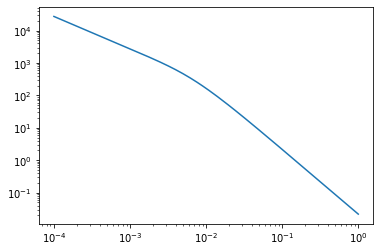

In [17]:
pl.loglog(a, TM, label = 'Tm')

In [18]:
recfast.__file__

'/home/daniel/anaconda3/envs/math/lib/python3.10/site-packages/recfast4py/recfast.py'

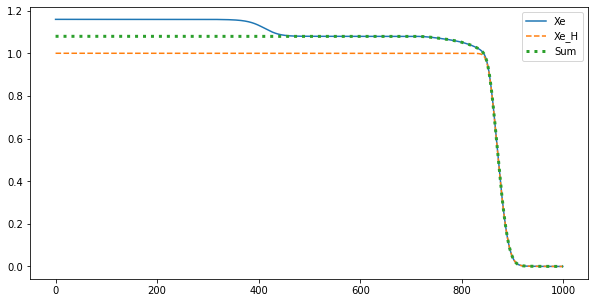

In [19]:
pl.figure(figsize=(10,5))
pl.plot(Xe, label = 'Xe')
pl.plot(Xe_H, label='Xe_H', ls='--')
pl.plot(np.array(Xe_He) + np.array(Xe_H), label='Sum', ls = ':', lw=3)
pl.legend()
# Xe seems to be the sum here https://lweb.cfa.harvard.edu/~sasselov/rec/code/main.c
# and here https://github.com/DonaldAirey/recfast-cplusplus/blob/master/Recfast/recombination.Recfast.cpp

In [14]:
from scipy.interpolate import interp1d

In [15]:
xe_a = interp1d(
            a, xe, bounds_error=False, fill_value=np.max(xe)
        )  # total free electron fraction Xe [1]
xe_h_a = interp1d(
    a, xe_h, bounds_error=False, fill_value=np.max(xe_h)
)  # H free electron fraction XeH [1]
xe_he_a = interp1d(
    a, xe_he, bounds_error=False, fill_value=np.max(xe_he)
)  # He free electron fraction XeHe [1]

In [20]:
# Compute logarithmic derivative of the baryon temperature
lna = np.log(a)
n_a = a.size
dlntmdlna = np.zeros(
    n_a
)  # logarithmic derivative dTm_dln(a) of the baryon temperature [1]
a_dlntmdlna = np.zeros(n_a)
for i in range(0, n_a - 1):
    a_dlntmdlna[i] = np.exp(0.5 * (lna[i] + lna[i + 1]))
    dlntmdlna[i] = (np.log(tm[i + 1]) - np.log(tm[i])) / (
        lna[i + 1] - lna[i]
    )
a_dlntmdlna[n_a - 1] = 1.0  # fill in a=1 value - Warning: a bit dangerous
dlntmdlna[n_a - 1] = -2.0
dlntmdlna_max = np.max(dlntmdlna)
dlntmdlna_a = interp1d(
    a_dlntmdlna, dlntmdlna, bounds_error=False, fill_value=dlntmdlna_max
)  # d(Tm)/d(ln a) [1]

In [22]:
c = 299792.458  # [km/s]
kb = 8.6173303e-5  # [eV/K]
evc2 = 1.782661907e-36  # [kg] - eV/c^2
G = 6.67408e-11  # [m^3/kg/s^2]
hbar = 6.582119514e-16  # eV s
mpc = 3.085677581491367e22  # [m]
mp = 938.2720813  # [MeV/c**2]
msun = 1.98848e30  # [kg]
sigmat = 6.6524587158e-29  # [m**2]
h = 0.7
H0 = 100 * h
omega_b = 0.05
rho_crit = (
            3.0
            * H0 ** 2
            / (8.0 * np.pi * G)
            * 1e6
            * mpc
            / msun
            / h ** 2
        )



def taudot_a(a):
    """
    Return tau_dot the derivative of the optical depth with respect to conformal
    time
    :param a:
    ;return: taudot: tou_dot=d(tau)/d(eta) [h Mpc^-1]
    """

    taudot_norm = (
        sigmat
        * (rho_crit * msun / mpc**3)
        / (mp * 1e6 * evc2)
    )  # sigma_thomson*rho_crit/m_p= 7.471e-28 h^2 m^-1
    return (
        -taudot_norm
        * mpc
        / a**2
        * xe_a(a)
        * omega_b
        * h
        * (1.0 - Yp)
    )

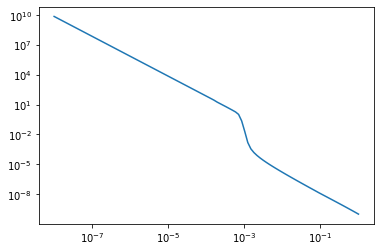

In [25]:
a_ = np.logspace(-10, 0, 100)
pl.loglog(a_, -taudot_a(a_))